In [46]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import imageio
import os
import glob
from scipy.integrate import odeint

In [2]:
def sir(f, t, beta, r, N):
    '''
    Generates SIR model.
    
    Arguments:
        f - S, I and R values
        t - time
        beta - transmission rate
        r - recovery rate
    '''
    
    S, I, R = f
    dS = -beta * S * I
    dI = beta * S * I - r * I
    dR = r * I

    return [dS, dI, dR]

def si(f, t, beta, N):
    '''
    Generates SI model.
    
    Arguments:
        f - S, I and R values
        t - time
        beta - transmission rate
    '''
    
    S, I = f
    dS = -beta * S * I 
    dI = beta * S * I 

    return [dS, dI]

def R0(beta, r):
    '''
    Calculates basic reproductive ratio.
    
    Arguments:
        beta - transmission rate
        r - recovery rate
    '''
    R_0 = beta * N / r
    return np.round(R_0, 4)

In [3]:
N = 1000
t = np.linspace(0, 1000, 1000)

bs = [0.1, 1, 50]
betas = [i/N for i in bs]
rs = [0.01, 1]

newBs = np.linspace(0.1, 1, 100)
newBetas = [1/N for i in newBs]
newRs = np.linspace(0.1, 1, 100)

In [ ]:
IC = [N - 1, 1, 0] # [susceptible, infected, recovered]

R_0s = ['R0']
bs = ['beta']
rs2 = ['r']
res_threshold = ['result from plot']

fig, axes = plt.subplots(len(betas), len(rs), figsize=(24, 20))

for i, b in enumerate(betas):
    for j, r in enumerate(rs):
        SIR = odeint(sir, IC, t, args = (b, r, N))
        S, I, R = SIR.T
        R_0 = R0(b, r)
        
        ax = axes[i, j]
        ax.plot(t, S, label='Susceptible')
        ax.plot(t, I, label='Infected')
        ax.plot(t, R, label='Recovered')
        
        ax.set_xlabel('t')
        ax.set_ylabel('N')
        ax.set_title(f'SIR model for beta = {b} and r = {r}; R0 = {R_0}')

        ax.legend()

        R_0s.append(R_0)
        bs.append(b)
        rs2.append(r)
        
        # checking if there is an epidemic using commonly used threshold that is a fraction of the total population,
        # in this case set to 0.1 (10%) of the population
        
        max_infected = np.max(I)
        if max_infected > 0.1 * N:
            res_threshold.append('epidemic')
        else:
            res_threshold.append('no epidemic')

plt.show()

In [ ]:
res = ['result from R0']

for i in range(1, len(R_0s)):
    if R_0s[i] > 1:
        res.append('epidemic')
    else:
        res.append('no epidemic')
        
tbl = zip(bs, rs2, R_0s, res, res_threshold)

for i in tbl:
    print("{:<10} {:<10} {:<10} {:<18} {:<10}".format(*i))

In [ ]:
fig, axes = plt.subplots(len(betas), 1, figsize=(8, 6*len(betas)))

for i, beta in enumerate(betas):
    s0 = np.linspace(1, N-1, 20)
    i0 = np.linspace(1, N-1, 20)
    
    S0, I0 = np.meshgrid(s0, i0)
    
    u, v = np.zeros(S0.shape), np.zeros(I0.shape)
    n1, n2 = S0.shape
    
    for j in range(n1):
        for k in range(n2):
            s = S0[j, k]
            ii = I0[j, k]
            
            SI = odeint(si, [s, ii], t, args=(beta, N))
            S, I = SI.T
            
            dS, dI = si([s, ii], 0, beta, N)
            u[j, k] = dS
            v[j, k] = dI
    
    ax = axes[i]
    ax.quiver(S0, I0, u, v)
    
    ax.set_xlabel('S')
    ax.set_ylabel('I')
    ax.set_title(f'S-I Phase Portrait for beta = {beta}')

plt.tight_layout()
plt.show()

In [ ]:
newBs = np.linspace(0.01, 1, 1000)
newBetas = [1/N for i in newBs]
newRs = np.linspace(0.01, 1, 1000)

IC = [N - 1, 1, 0] # [susceptible, infected, recovered]

totalI = []
R0Vals = []

for b in newBetas:
    for r in newRs:
        SIR = odeint(sir, IC, t, args = (b, r, N))
        S, I, R = SIR.T
        totalI.append(np.max(I))
        R0Vals.append(R0(b, r))
        
plt.scatter(R0Vals, totalI, s = 1, c = 'red')
plt.xlabel('R0')
plt.ylabel('I (total infections)')
plt.title('SIR model I vs R0')
plt.show()

In [11]:
def SIRonLatticeInfectedFrac(xsize=10, ysize=10, ps=[0.4], iterations=50, runs=100):
    G = nx.grid_2d_graph(xsize, ysize)

    for node in G.nodes:
        G.nodes[node]['state'] = 'S'

    init = random.choice(list(G.nodes))
    G.nodes[init]['state'] = 'I'

    infectedFrac = np.zeros((runs, iterations + 1, len(ps)))

    for run in range(runs):
        for p_idx, p in enumerate(ps):
            for node in G.nodes:
                G.nodes[node]['state'] = 'S'
            G.nodes[init]['state'] = 'I'

            infectedFrac[run][0][p_idx] = 1 / (xsize * ysize)

            for t in range(1, iterations + 1):
                infectedNodes = []
                for node in G.nodes:
                    if G.nodes[node]['state'] == 'I':
                        infectedNodes.append(node)

                for node in infectedNodes:
                    neighbors = list(G.neighbors(node))
                    susceptibleNeighbors = []
                    for n in neighbors:
                        if G.nodes[n]['state'] == 'S':
                            susceptibleNeighbors.append(n)

                    for neighbor in susceptibleNeighbors:
                        q = random.random()
                        if q < p:
                            G.nodes[neighbor]['state'] = 'I'

                    G.nodes[node]['state'] = 'R'

                numInfected = len([node for node in G.nodes if G.nodes[node]['state'] == 'I'])
                infectedFracOneRun = numInfected / (xsize * ysize)
                infectedFrac[run][t][p_idx] = infectedFracOneRun

    return infectedFrac

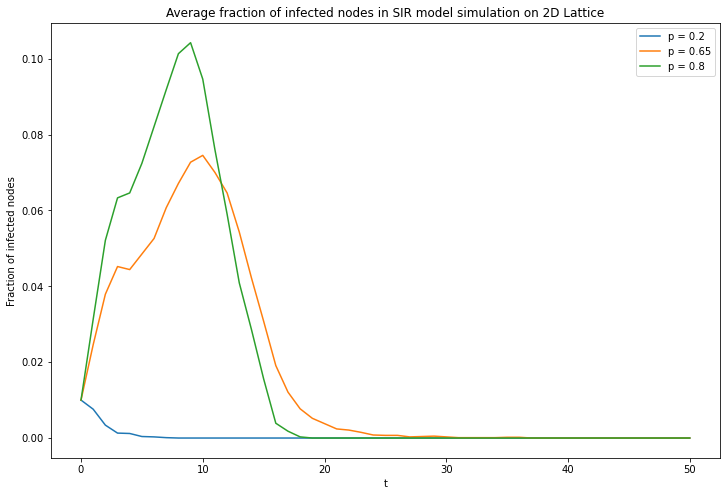

In [15]:
ps = [0.2, 0.65, 0.8]

infectedFractions = SIRonLatticeInfectedFrac(ps=ps)
avgInfectedFractions = np.mean(infectedFractions, axis=0)

plt.figure(figsize=(12, 8))

for p_idx, p in enumerate(ps):
    plt.plot(range(51), avgInfectedFractions[:, p_idx], label = f'p = {p}')

plt.xlabel('t')
plt.ylabel('Fraction of infected nodes')
plt.title('Average fraction of infected nodes in SIR model simulation on 2D Lattice')
plt.legend()
plt.show()        

In [42]:
def SIRonLatticeDynamics(xsize=10, ysize=10, ps=[0.4], iterations=50, runs=100):
    G = nx.grid_2d_graph(xsize, ysize)

    for node in G.nodes:
        G.nodes[node]['state'] = 'S'

    infectedFrac = np.zeros((runs, len(ps)))
    timeToClear = np.zeros((runs, len(ps)))
    timeToMaxInfected = np.zeros((runs, len(ps)))

    for run in range(runs):
        for p_idx, p in enumerate(ps):
            for node in G.nodes:
                G.nodes[node]['state'] = 'S'

            init = random.choice(list(G.nodes))
            G.nodes[init]['state'] = 'I'

            infectedCount = [1]
            maxInfectedCount = 1
            timeOfMaxInfected = 0

            for t in range(1, iterations + 1):
                infectedNodes = [node for node in G.nodes if G.nodes[node]['state'] == 'I']

                for node in infectedNodes:
                    neighbors = list(G.neighbors(node))
                    susceptibleNeighbors = [n for n in neighbors if G.nodes[n]['state'] == 'S']

                    for neighbor in susceptibleNeighbors:
                        q = random.random()
                        if q < p:
                            G.nodes[neighbor]['state'] = 'I'

                    G.nodes[node]['state'] = 'R'

                numInfected = len([node for node in G.nodes if G.nodes[node]['state'] == 'I'])

                if numInfected == 0 and 'I' not in [G.nodes[node]['state'] for node in G.nodes]:
                    timeToClear[run][p_idx] = t
                    timeToMaxInfected[run][p_idx] = timeOfMaxInfected
                    break

                infectedCount.append(numInfected)
                if numInfected > maxInfectedCount:
                    maxInfectedCount = numInfected
                    timeOfMaxInfected = t

                infectedFraction = numInfected / (xsize * ysize)
                infectedFrac[run][p_idx] = infectedFraction

    return infectedFrac, timeToClear, timeToMaxInfected

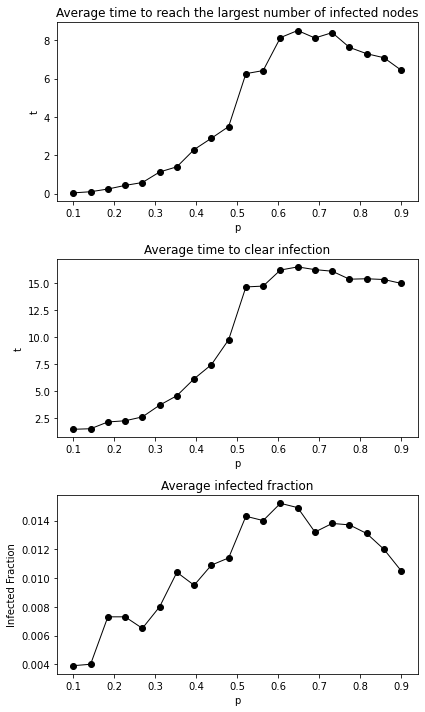

In [43]:
ps = np.linspace(0.1, 0.9, 20)

infectedFrac, timeToClear, timeToMaxInfected = SIRonLatticeDynamics(ps=ps)
avgTimeToClear = np.mean(timeToClear, axis=0)
avgTimeToMaxInfected = np.mean(timeToMaxInfected, axis=0)
avgInfectedFrac = np.mean(infectedFrac, axis=0)

plt.figure(figsize=(6, 10))

plt.subplot(3, 1, 1)
plt.plot(ps, avgTimeToMaxInfected, linewidth=1, c='black', marker='o')
plt.xlabel('p')
plt.ylabel('t')
plt.title('Average time to reach the largest number of infected nodes')

plt.subplot(3, 1, 2)
plt.plot(ps, avgTimeToClear, linewidth=1, c='black', marker='o')
plt.xlabel('p')
plt.ylabel('t')
plt.title('Average time to clear infection')

plt.subplot(3, 1, 3)
plt.plot(ps, avgInfectedFrac, linewidth=1, c='black', marker='o')
plt.xlabel('p')
plt.ylabel('Infected Fraction')
plt.title('Average infected fraction')

plt.tight_layout()
plt.show()

In [58]:
def SIRonLatticeGenerateMovie(xsize=10, ysize=10, p=0.8, iterations=100):
    if not os.path.exists('2DLatticeMovie'):
        os.makedirs('2DLatticeMovie')
        
    files = glob.glob(os.path.join('2DLatticeMovie', '*')) # get access to all files in a folder
    for f in files:
        os.remove(f)
    
    colorMap = {'S': 'blue', 'I': 'red', 'R': 'green'}
    
    G = nx.grid_2d_graph(xsize, ysize)

    for node in G.nodes:
        G.nodes[node]['state'] = 'S'

    init = random.choice(list(G.nodes))
    G.nodes[init]['state'] = 'I'

    states = nx.get_node_attributes(G, 'state')
    
    plt.figure(figsize=(6, 6))
    pos = {node: (node[1], node[0]) for node in G.nodes}
    nx.draw(G, pos = pos, node_color = [colorMap[states[node]] for node in G.nodes],
            node_size = 200, with_labels = False)
    
    plt.savefig(os.path.join('2DLatticeMovie', f'img_{0}.png'))
    plt.close()
    
    for t in range(1, iterations + 1):
        infectedNodes = [node for node in G.nodes if G.nodes[node]['state'] == 'I']

        for node in infectedNodes:
            neighbors = list(G.neighbors(node))
            susceptibleNeighbors = [n for n in neighbors if G.nodes[n]['state'] == 'S']

            for neighbor in susceptibleNeighbors:
                q = random.random()
                if q < p:
                    G.nodes[neighbor]['state'] = 'I'

            G.nodes[node]['state'] = 'R'

        states = nx.get_node_attributes(G, 'state')
            
        plt.figure(figsize=(6, 6))
        pos = {node: (node[1], node[0]) for node in G.nodes}
        nx.draw(G, pos = pos, node_color = [colorMap[states[node]] for node in G.nodes],
                node_size = 200, with_labels = False)

        plt.savefig(os.path.join('2DLatticeMovie', f'img_{t}.png'))
        plt.close()
        
    with imageio.get_writer('2DLattice.mp4', mode = 'I', fps = 5) as w:
        for i in range(iterations + 1):
            file = os.path.join('2DLatticeMovie', f'img_{i}.png')
            img = imageio.imread(file)
            w.append_data(img)

In [61]:
SIRonLatticeGenerateMovie(xsize=10, ysize=10, p=0.65, iterations=50)